# **Bài toán: Dự đoán lượng hàng hóa sẽ được bán trong ngày.**

**Input: Dữ liệu số lượng hàng bán hàng ngày của một cửa hàng online**

**Outcome: Dự đoán số lượng một số loại hàng sẽ được bán trong các ngày tiếp theo**

In [ ]:
#Import các thư viện
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.axes
import datetime
!pip install catboost
!pip install shap
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

     |████████████████████████████████| 66.2MB 57kB/s 
     |████████████████████████████████| 327kB 6.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463910 sha256=aff29c5978414a557d1c90b04291a18615ff80afb81681ea5927fb9d5ce05b3c
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Học DS/E-Commerce sales forecast
!ls

/content/drive/My Drive/Học DS/E-Commerce sales forecast
 data_sale.csv	'Dự báo doanh số.gslides'  'Sales Forecast'


In [ ]:
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
data = pd.read_csv('data_sale.csv', encoding="ISO-8859-1")
data.columns = columns

Tập dữ liệu bao gồm 541909 dữ liệu với 8 thuộc tính

In [ ]:
#Kiểm tra dữ liệu
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


# 1. Kiểm tra StockCode

In [ ]:
data.StockCode.describe()

count     541909
unique      4070
top       85123A
freq        2313
Name: StockCode, dtype: object

Text(0.5, 1.0, 'Các mã hàng phổ biến nhất')

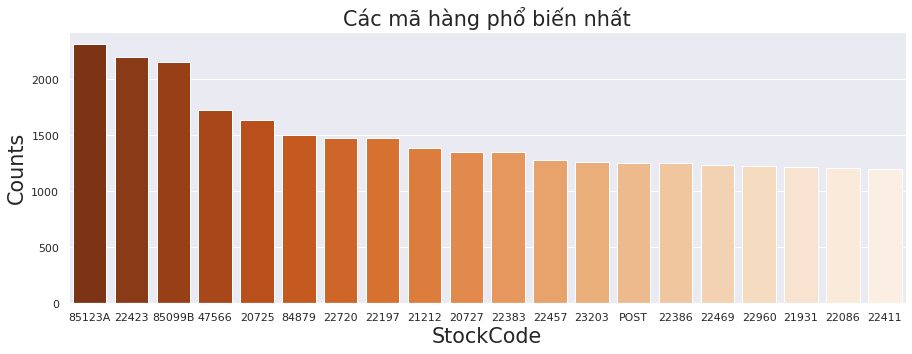

In [ ]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (15,5), facecolor = 'w')
sns.barplot(stockcode_counts.iloc[0:20].index,
              stockcode_counts.iloc[0:20].values,
              ax = ax, palette = "Oranges_r")
plt.ylabel("Counts", size = 'xx-large')
plt.xlabel("StockCode", size = 'xx-large')
plt.title("Các mã hàng phổ biến nhất", size = 'xx-large')

Các mã sẽ được lọc ra để dự đoán: 22423, 47566, 20725, 84879, 22197.

# Tạo bảng dữ liệu mới tương ứng với các mã trên

In [ ]:
index = np.where(data['StockCode'] == '22423')

In [ ]:
data_input = data.iloc[index]
data_input.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
880,536477,22423,REGENCY CAKESTAND 3 TIER,16,12/1/2010 12:27,10.95,16210.0,United Kingdom
936,536502,22423,REGENCY CAKESTAND 3 TIER,2,12/1/2010 12:36,12.75,16552.0,United Kingdom
1092,536525,22423,REGENCY CAKESTAND 3 TIER,2,12/1/2010 12:54,12.75,14078.0,United Kingdom
1155,536528,22423,REGENCY CAKESTAND 3 TIER,1,12/1/2010 13:17,12.75,15525.0,United Kingdom
1197,536530,22423,REGENCY CAKESTAND 3 TIER,1,12/1/2010 13:21,12.75,17905.0,United Kingdom


In [ ]:
data_input.describe()

,Quantity,UnitPrice,CustomerID
count,2203.000000,2203.000000,1905.000000
mean,5.891966,13.781484,14946.686614
std,15.044987,4.158712,1673.826563
min,-150.000000,0.000000,12347.000000
25%,1.000000,12.750000,13517.000000
50%,2.000000,12.750000,14911.000000
75%,6.000000,12.750000,16131.000000
max,272.000000,32.040000,18282.000000


In [ ]:
data_input.shape

(2203, 8)

In [ ]:
data_input['InvoiceDate'] = pd.to_datetime(data_input.InvoiceDate)
data_input['Revenue'] = data_input.Quantity * data_input.UnitPrice
data_input['Year'] = data_input.InvoiceDate.dt.year
data_input['Quarter'] = data_input.InvoiceDate.dt.quarter
data_input["Month"] = data_input.InvoiceDate.dt.month
data_input["Week"] = data_input.InvoiceDate.dt.week
data_input["Weekday"] = data_input.InvoiceDate.dt.weekday
data_input["Day"] = data_input.InvoiceDate.dt.day
data_input["Dayofyear"] = data_input.InvoiceDate.dt.dayofyear
data_input["Date"] = pd.to_datetime(data_input[['Year', 'Month', 'Day']])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
data_input.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
880,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom,175.20,2010,4,12,48,2,1,335,2010-12-01
936,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
1092,536525,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:54:00,12.75,14078.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
1155,536528,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:17:00,12.75,15525.0,United Kingdom,12.75,2010,4,12,48,2,1,335,2010-12-01
1197,536530,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:21:00,12.75,17905.0,United Kingdom,12.75,2010,4,12,48,2,1,335,2010-12-01
1341,536537,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 13:51:00,12.75,15922.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
1390,536539,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 14:03:00,12.75,15165.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
1576,536544,22423,REGENCY CAKESTAND 3 TIER,40,2010-12-01 14:32:00,12.72,NaN,United Kingdom,508.80,2010,4,12,48,2,1,335,2010-12-01
2147,536562,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 15:08:00,12.75,13468.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
2723,536592,22423,REGENCY CAKESTAND 3 TIER,47,2010-12-01 17:06:00,12.72,NaN,United Kingdom,597.84,2010,4,12,48,2,1,335,2010-12-01


In [ ]:
data_input.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
Revenue               float64
Year                    int64
Quarter                 int64
Month                   int64
Week                    int64
Weekday                 int64
Day                     int64
Dayofyear               int64
Date           datetime64[ns]
dtype: object

In [ ]:
data_input.isnull().sum()

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID     298
Country          0
Revenue          0
Year             0
Quarter          0
Month            0
Week             0
Weekday          0
Day              0
Dayofyear        0
Date             0
dtype: int64

# Kiểm tra các thuộc tính của dữ liệu


## InvoiceNo

In [ ]:
print('Tổng số hóa đơn: ',data_input.InvoiceNo.nunique())

Tổng số hóa đơn:  2172


Text(0.5, 1.0, 'Các hóa đơn lần xuất hiện nhiều nhất')

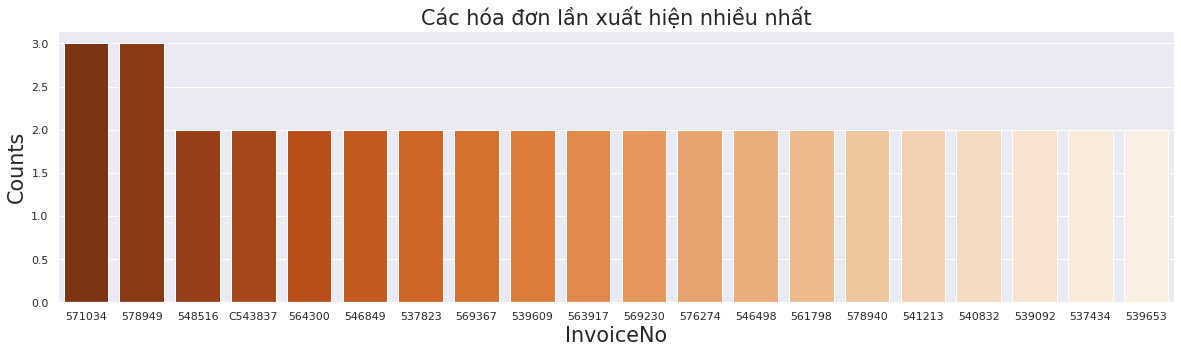

In [ ]:
InvoiceNo_counts = data_input.InvoiceNo.value_counts().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (20,5), facecolor = 'w')
sns.barplot(InvoiceNo_counts.iloc[0:20].index,
              InvoiceNo_counts.iloc[0:20].values,
              ax = ax, palette = "Oranges_r")
plt.ylabel("Counts", size = 'xx-large')
plt.xlabel("InvoiceNo", size = 'xx-large')
plt.title("Các hóa đơn lần xuất hiện nhiều nhất", size = 'xx-large')

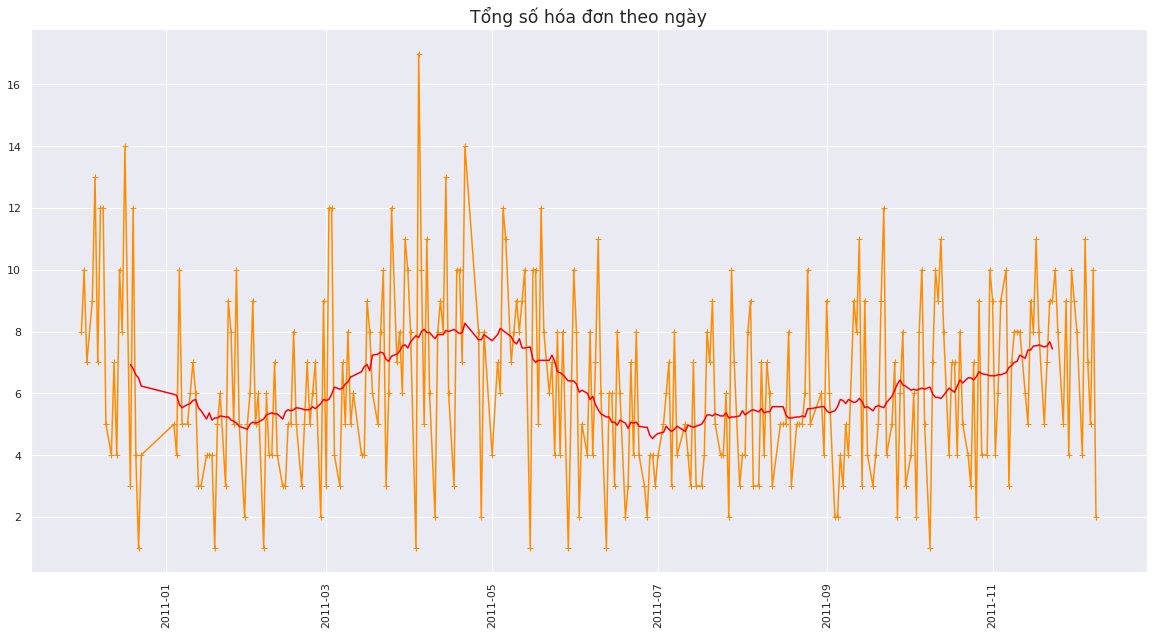

In [ ]:
plt.figure(figsize=(20,10), facecolor= 'w')
plt.plot(data_input.groupby("Date").InvoiceNo.nunique(), marker='+', c="darkorange")
plt.plot(data_input.groupby("Date").InvoiceNo.nunique().rolling(window=30, center=True).mean(),c="red")
plt.xticks(rotation=90);
plt.title("Tổng số hóa đơn theo ngày", size = 'x-large');

In [ ]:
a = np.where(data_input.InvoiceNo == '571034')
a

(array([1811, 1812, 1813]),)

In [ ]:
data_input.iloc[a]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
395372,571034,22423,REGENCY CAKESTAND 3 TIER,4,2011-10-13 12:47:00,12.75,12359.0,Cyprus,51.00,2011,4,10,41,3,13,286,2011-10-13
395435,571034,22423,REGENCY CAKESTAND 3 TIER,6,2011-10-13 12:47:00,12.75,12359.0,Cyprus,76.50,2011,4,10,41,3,13,286,2011-10-13
395456,571034,22423,REGENCY CAKESTAND 3 TIER,3,2011-10-13 12:47:00,12.75,12359.0,Cyprus,38.25,2011,4,10,41,3,13,286,2011-10-13


## Quantity

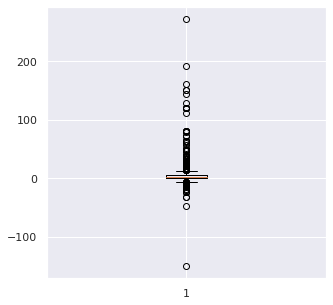

In [ ]:
plt.figure(figsize=(5,5), facecolor= 'w' )
plt.boxplot(data_input.Quantity)
plt.show()

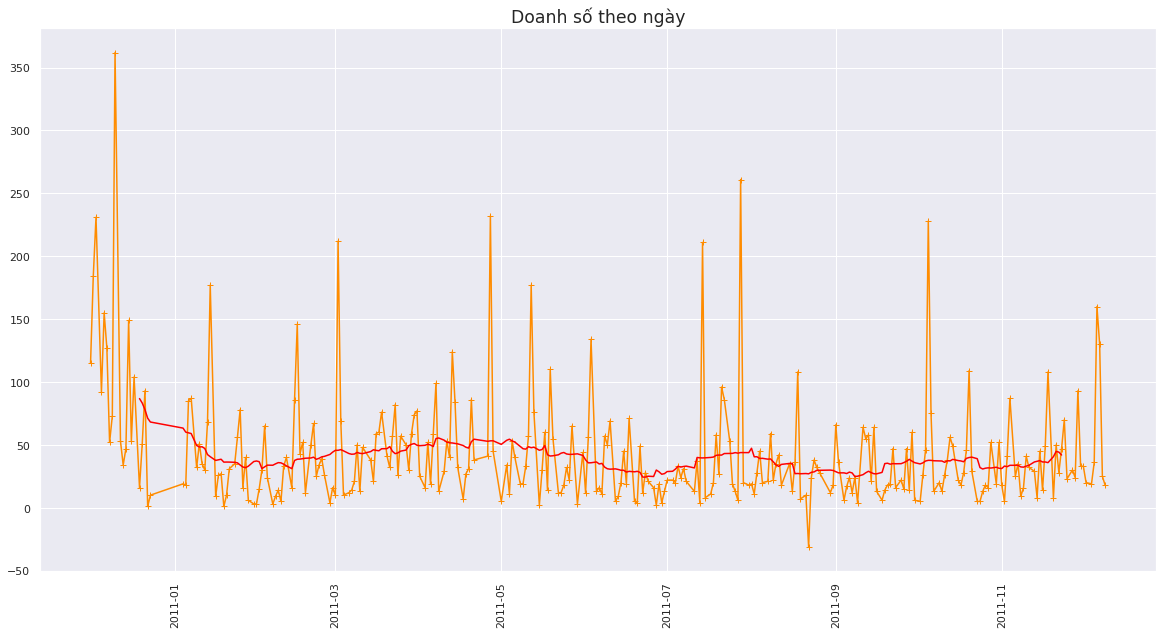

In [ ]:
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(data_input.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(data_input.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("Doanh số theo ngày", size = 'x-large');

Loại bỏ những hóa đơn có số lượng nhỏ hơn 0

In [ ]:
index_true = np.array(np.where(data_input['Quantity'] > 0)).ravel()
data_input = data_input.iloc[index_true]

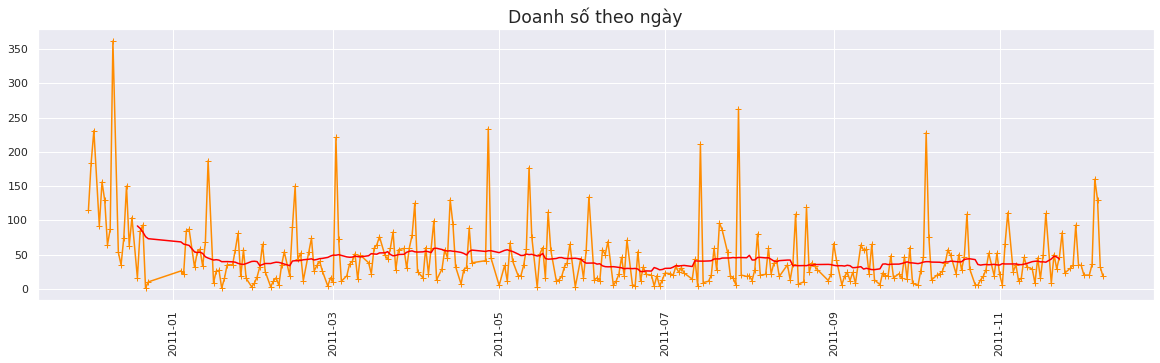

In [ ]:
plt.figure(figsize=(20,5), facecolor= 'w')
plt.plot(data_input.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(data_input.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("Doanh số theo ngày", size = 'x-large');

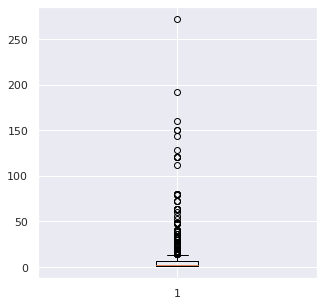

In [ ]:
plt.figure(figsize=(5,5), facecolor= 'w' )
plt.boxplot(data_input.Quantity)
plt.show()

Loại bỏ những hóa đơn có số lượng cao đột biến

Text(0.5, 0, 'Số lượng Log tự nhiên')

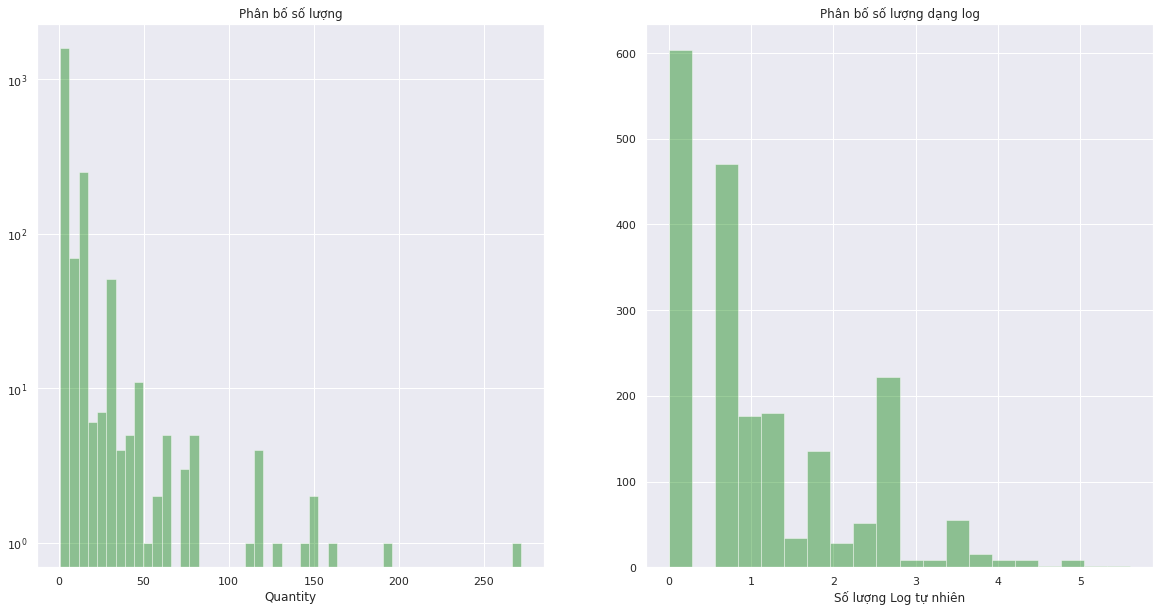

In [ ]:
#Sử dụng hàm Log để loại một số hóa đơn mà có số lượng mua cao đột biến
fig, ax = plt.subplots(1,2, figsize = (20,10), facecolor = 'w')
sns.distplot(data_input.Quantity, ax = ax[0], kde = False, color = 'green')
sns.distplot(np.log(data_input.Quantity), ax = ax[1], bins = 20, kde = False, color= 'green')
ax[0].set_title('Phân bố số lượng')
ax[0].set_yscale('log')
ax[1].set_title('Phân bố số lượng dạng log')
ax[1].set_xlabel('Số lượng Log tự nhiên')

In [ ]:
np.exp(3)

20.085536923187668

In [ ]:
#95% lượng phân bố:
np.quantile(data_input.Quantity, 0.95)

24.09999999999991

Lấy data để luyện cho model


In [ ]:
index_true = np.array(np.where(data_input['Quantity'] < 24)).ravel()
data_input = data_input.iloc[index_true]

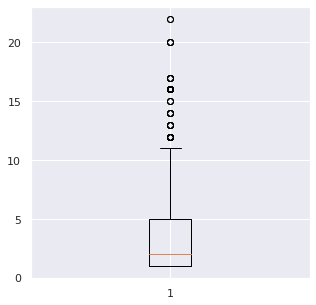

In [ ]:
plt.figure(figsize=(5,5), facecolor= 'w' )
plt.boxplot(data_input.Quantity)
plt.show()

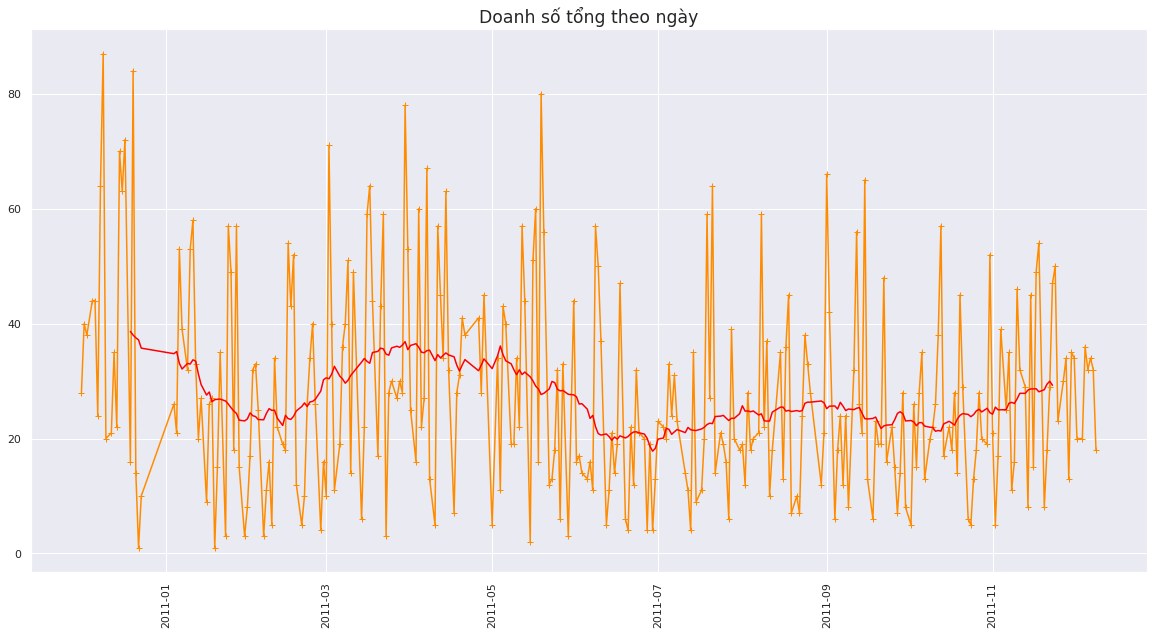

In [ ]:
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(data_input.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(data_input.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("Doanh số tổng theo ngày", size = 'x-large');

Nhận xét:
1. Tháng 12 là có doanh số

In [ ]:
data_input.describe()

,Quantity,UnitPrice,CustomerID,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear
count,1913.000000,1913.000000,1630.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000
mean,4.353372,14.079158,14985.603067,57.228939,2010.917407,2.593832,6.829064,27.552013,2.421850,14.892316,191.368531
std,4.846122,4.281251,1667.455482,62.079610,0.275338,1.143338,3.529249,15.236989,1.749263,8.641083,106.833555
min,1.000000,0.000000,12347.000000,0.000000,2010.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
25%,1.000000,12.750000,13616.250000,12.750000,2011.000000,2.000000,4.000000,14.000000,1.000000,7.000000,96.000000
50%,2.000000,12.750000,14911.000000,25.500000,2011.000000,3.000000,7.000000,27.000000,2.000000,15.000000,189.000000
75%,5.000000,12.750000,16207.750000,74.880000,2011.000000,4.000000,10.000000,42.000000,4.000000,22.000000,291.000000
max,22.000000,32.040000,18282.000000,549.120000,2011.000000,4.000000,12.000000,51.000000,6.000000,31.000000,357.000000


## Unit Price

In [ ]:
data_input.UnitPrice.describe()

count    1913.000000
mean       14.079158
std         4.281251
min         0.000000
25%        12.750000
50%        12.750000
75%        12.750000
max        32.040000
Name: UnitPrice, dtype: float64

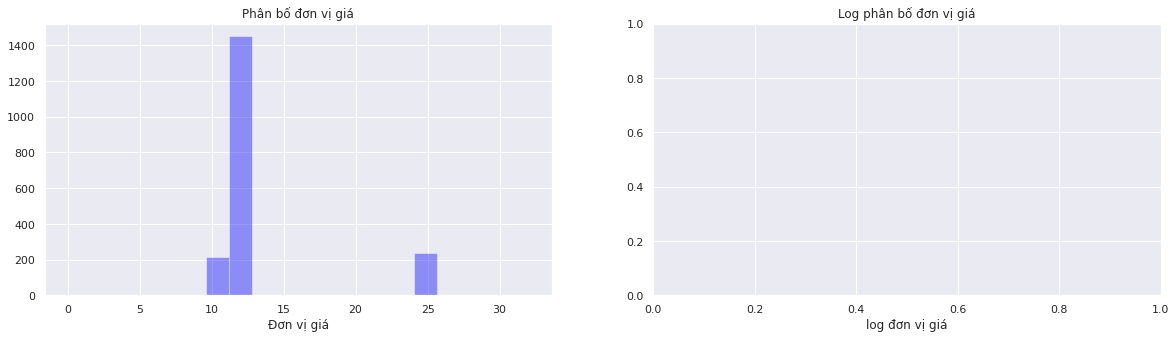

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (20,5), facecolor = 'w')
sns.distplot(data_input['UnitPrice'], kde = False, bins = 20, ax = ax[0], color = 'blue')
#sns.distplot(np.log(data_train['UnitPrice']), kde = False, bins = 20, ax = ax[1], color = 'blue')
ax[0].set_xlabel('Đơn vị giá')
ax[0].set_title('Phân bố đơn vị giá')
ax[1].set_xlabel('log đơn vị giá')
ax[1].set_title('Log phân bố đơn vị giá')
plt.show()

In [ ]:
max = np.where(data_input['UnitPrice'] == data_input['UnitPrice'].max())
min = np.where(data_input['UnitPrice'] == data_input['UnitPrice'].min())
data_input.iloc[max]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
503934,578940,22423,REGENCY CAKESTAND 3 TIER,1,2011-11-27 13:18:00,32.04,NaN,United Kingdom,32.04,2011,4,11,47,6,27,331,2011-11-27
509045,579291,22423,REGENCY CAKESTAND 3 TIER,1,2011-11-29 11:21:00,32.04,NaN,United Kingdom,32.04,2011,4,11,48,1,29,333,2011-11-29
529835,580754,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-06 10:05:00,32.04,NaN,United Kingdom,32.04,2011,4,12,49,1,6,340,2011-12-06
537367,581256,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 11:21:00,32.04,NaN,United Kingdom,32.04,2011,4,12,49,3,8,342,2011-12-08


In [ ]:
data_input.iloc[min]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0.0,2010,4,12,51,1,21,355,2010-12-21
53391,540832,22423,REGENCY CAKESTAND 3 TIER,1,2011-01-11 14:42:00,0.0,NaN,United Kingdom,0.0,2011,1,1,2,1,11,11,2011-01-11


## Customer

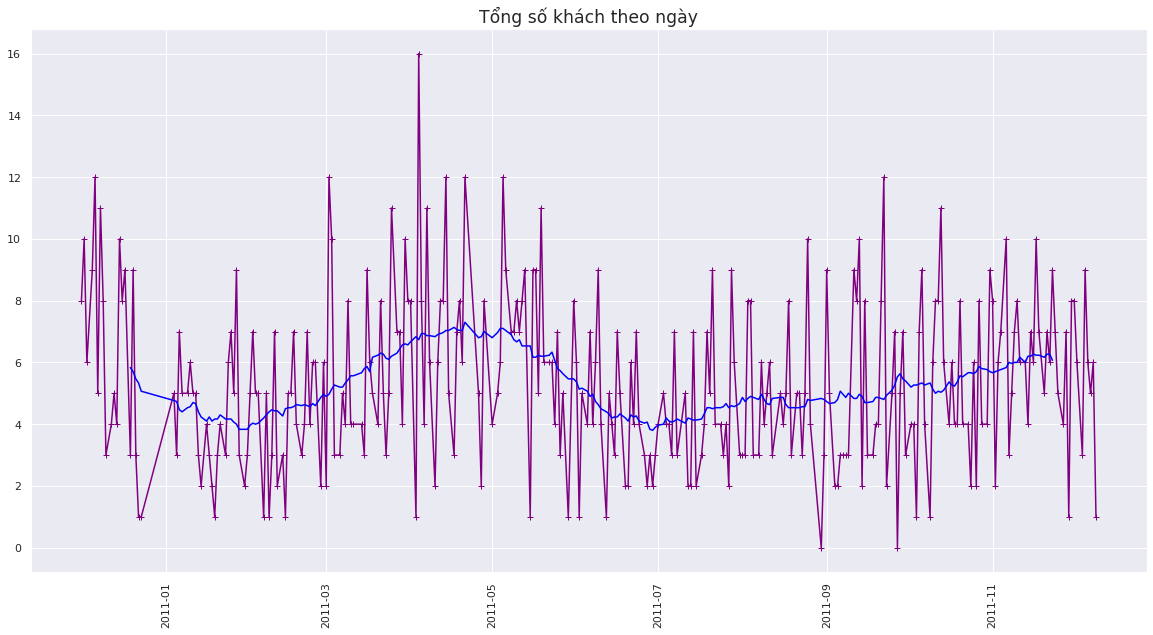

In [ ]:
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(data_input.groupby("Date").CustomerID.nunique(), marker='+', c="purple")
plt.plot(data_input.groupby("Date").CustomerID.nunique().rolling(window=30, center=True).mean(),c="blue")
plt.xticks(rotation=90);
plt.title("Tổng số khách theo ngày", size = 'x-large');

In [ ]:
data_input['CustomerID'].isnull().sum()


283

Xử lý các hóa đơn có CustomerID ẩn danh

In [ ]:
none_name = np.where(data_input['CustomerID'].isnull() == False)
data_input.iloc[none_name]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
880,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom,175.20,2010,4,12,48,2,1,335,2010-12-01
936,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
1092,536525,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:54:00,12.75,14078.0,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
1155,536528,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:17:00,12.75,15525.0,United Kingdom,12.75,2010,4,12,48,2,1,335,2010-12-01
1197,536530,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:21:00,12.75,17905.0,United Kingdom,12.75,2010,4,12,48,2,1,335,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538944,581425,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 15:31:00,12.75,14796.0,United Kingdom,12.75,2011,4,12,49,3,8,342,2011-12-08
539891,581449,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 17:37:00,12.75,12748.0,United Kingdom,12.75,2011,4,12,49,3,8,342,2011-12-08
539892,581449,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 17:37:00,12.75,12748.0,United Kingdom,12.75,2011,4,12,49,3,8,342,2011-12-08
540216,581472,22423,REGENCY CAKESTAND 3 TIER,2,2011-12-08 19:55:00,12.75,15796.0,United Kingdom,25.50,2011,4,12,49,3,8,342,2011-12-08


# Dự đoán doanh số

Dữ liệu đào tạo: Doanh số; lượng khách hàng; thời gian tương ứng

Input bài toán: Thời điểm bất kì trong tương lai.

Output mong muốn: Doanh số của một sản phẩm trong ngày hôm đó.

## Linear regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
#Loại bỏ những ID khuyết
valid_id = np.where(data_input['CustomerID'].isnull() == False)
data_train = data_input.iloc[valid_id]
data_train['NumOfCustomer'] = data_train.groupby('Dayofyear').CustomerID.nunique()
data_train.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1630, 18)

In [ ]:
Num_of_customer = data_train.groupby('Dayofyear').CustomerID.nunique().T
day = np.sort(data_train['Dayofyear'].unique()).T
dataset = pd.DataFrame(data = np.array(Num_of_customer), columns = ['NOC'])
dataset['Dayofyear'] = day
Qty = np.array(data_train.groupby('Dayofyear').Quantity.sum())
dataset['Qty'] = Qty
dataset.head(10)

,NOC,Dayofyear,Qty
0,5,4,26
1,3,5,20
2,7,6,40
3,5,7,39
4,5,9,32
5,6,10,53
6,5,11,39
7,5,12,32
8,3,13,20
9,2,14,21


[Text(0.5, 0, 'NOC'), Text(1.5, 0, 'Dayofyear'), Text(2.5, 0, 'Qty')]

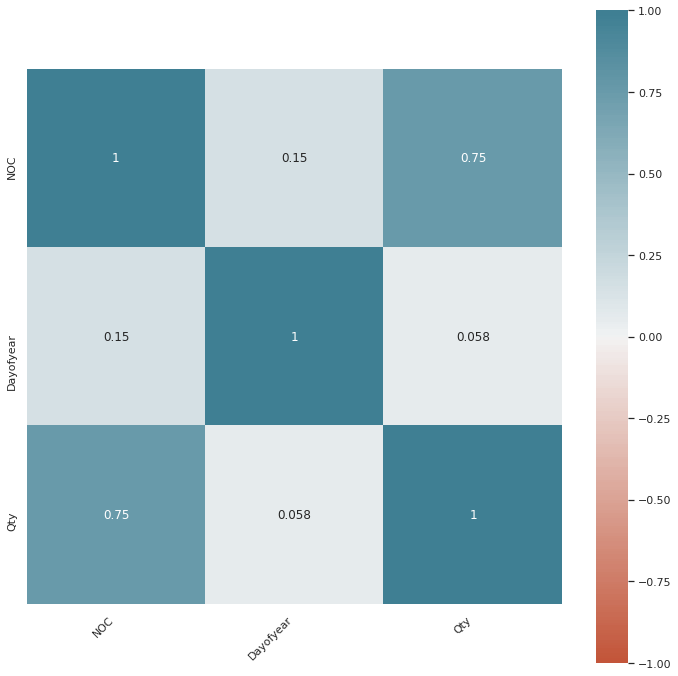

In [ ]:
# correlation
#set_option('precision', 2)
cor = dataset.corr(method='pearson')
fig, ax = plt.subplots(figsize=(12,12), facecolor = 'w')         # Sample figsize in inches
sns.heatmap(
    cor, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [ ]:
X_input = dataset[['NOC','Dayofyear']]
y_input = dataset['Qty']

In [ ]:
#Chia dữ liệu thành train và test
validation_size = 0.2
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(X_input, y_input, test_size = validation_size)

In [ ]:
X_train.shape, y_validation.shape

((233, 2), (59,))

In [ ]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

In [ ]:
print(X_train)

     NOC  Dayofyear
158    3        198
22     2         30
173    8        215
186    3        231
8      3         13
..   ...        ...
134    5        168
264    9        327
7      5         12
212   12        265
224    4        280

[233 rows x 2 columns]


In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('RD', Ridge()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [ ]:
#Đánh giá từng model dự đoán:
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits= num_folds, random_state= seed)
  #Đánh giá bằng hệ số Cross
  cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring= scoring)
  results.append(cv_results)
  names.append(name)
  message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(message)

LR: -147.703380 (59.772733)
RD: -147.698266 (59.799048)
LASSO: -147.663111 (61.035365)
EN: -148.041998 (63.128842)
KNN: -287.017514 (102.811417)
CART: -211.362500 (42.514966)
SVR: -333.657511 (139.163666)


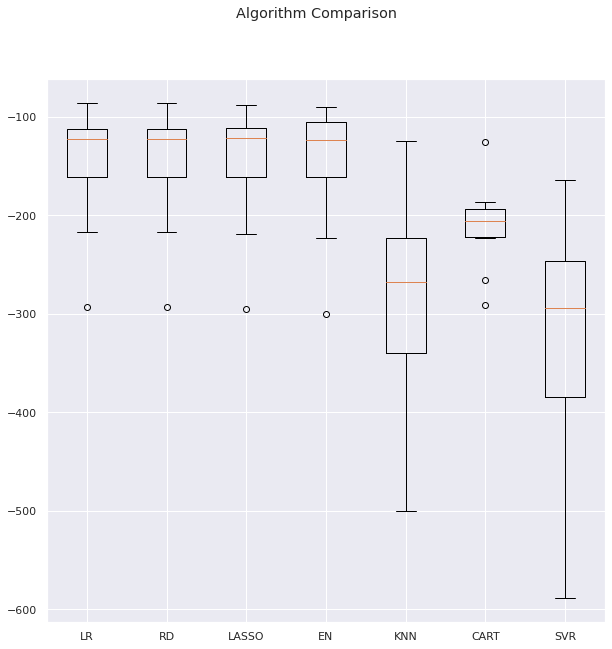

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor= 'w')
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: -147.703380 (59.772733)
ScaledLASSO: -147.045469 (63.880636)
ScaledEN: -167.730863 (76.673871)
ScaledKNN: -141.772145 (43.444347)
ScaledCART: -212.910326 (40.120452)
ScaledSVR: -213.109455 (92.378078)


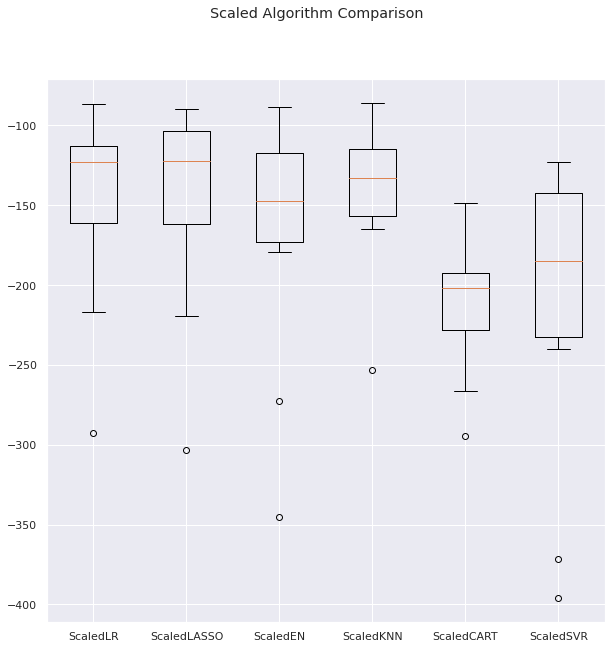

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10, 10), facecolor = 'w')
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits = num_folds, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -138.794198 using {'n_neighbors': 13}
-242.354891 (62.336349) with: {'n_neighbors': 1}
-151.682870 (38.847607) with: {'n_neighbors': 3}
-143.151312 (42.699516) with: {'n_neighbors': 5}
-144.479899 (48.197111) with: {'n_neighbors': 7}
-140.353218 (55.424193) with: {'n_neighbors': 9}
-141.206799 (59.918191) with: {'n_neighbors': 11}
-138.794198 (60.113685) with: {'n_neighbors': 13}
-140.242465 (58.574143) with: {'n_neighbors': 15}
-139.473149 (60.029177) with: {'n_neighbors': 17}
-144.693458 (65.646212) with: {'n_neighbors': 19}
-145.648784 (66.847071) with: {'n_neighbors': 21}


In [ ]:
# ensembles
ensembles = []
# boosting
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
# bagging
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -130.836426 (36.307317)
ScaledGBM: -132.757172 (30.821112)
ScaledRF: -153.068541 (36.836595)
ScaledET: -183.504299 (37.818307)


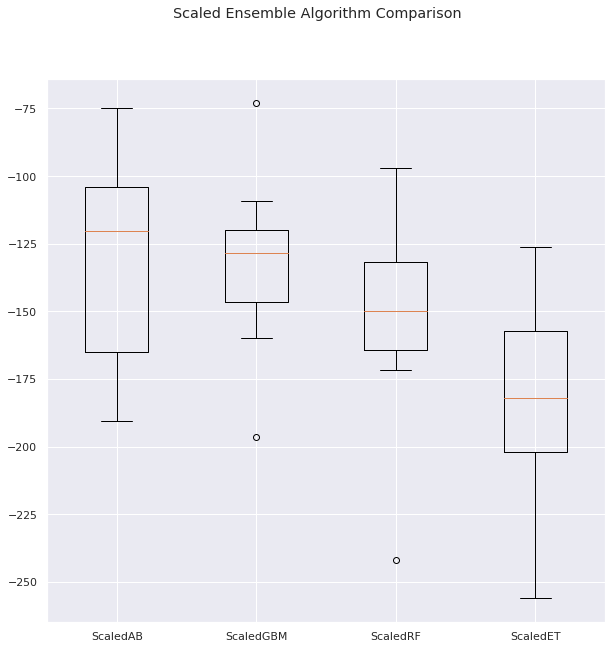

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor= 'w')
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Sau kết quả thử Cross Validation, ta thấy thuật toán ScaledGBM cho kết quả tốt nhất

In [ ]:
#Chạy với thuật toán AdaBoost
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators = np.array([50,100,150,200,250,300,350,400]))
model = AdaBoostRegressor(random_state = seed)
kfold = KFold(n_splits = num_folds, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -136.381704 using {'n_estimators': 50}
-136.381704 (29.921044) with: {'n_estimators': 50}
-136.381704 (29.921044) with: {'n_estimators': 100}
-136.381704 (29.921044) with: {'n_estimators': 150}
-136.381704 (29.921044) with: {'n_estimators': 200}
-136.381704 (29.921044) with: {'n_estimators': 250}
-136.381704 (29.921044) with: {'n_estimators': 300}
-136.381704 (29.921044) with: {'n_estimators': 350}
-136.381704 (29.921044) with: {'n_estimators': 400}


In [ ]:
#Chuẩn bị cho model, với n_estimators = 50
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = AdaBoostRegressor(random_state = seed, n_estimators = 50)
model.fit(rescaledX, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=7)

In [ ]:
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(y_validation, predictions))

142.525788503094


In [ ]:
y_predict = model.predict(X_input)

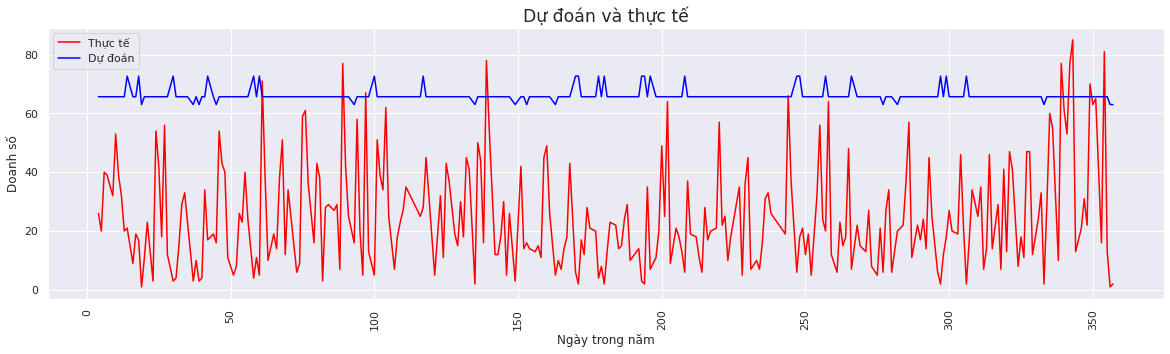

In [ ]:
plt.figure(figsize=(20,5), facecolor = 'w')
plt.plot(X_input['Dayofyear'], y_input, color = 'red', label = 'Thực tế')
plt.plot(X_input['Dayofyear'], y_predict, color = 'blue', label = 'Dự đoán')
plt.xlabel('Ngày trong năm')
plt.ylabel('Doanh số')
plt.legend(loc = 'best')
plt.xticks(rotation=90)
plt.title("Dự đoán và thực tế", size = 'x-large')
plt.show()

## Linear Regression P2

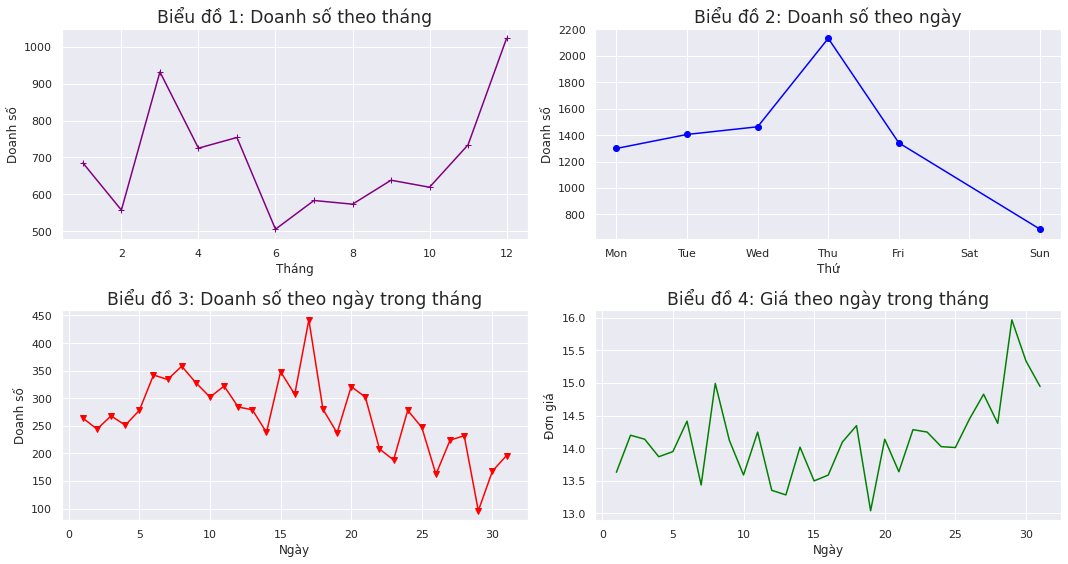

In [ ]:
#Doanh thu và tháng
fig, ax = plt.subplots(2,2,figsize=(15,8), facecolor = 'w', tight_layout = 10)
ax[0,0].plot(data_input.groupby("Month").Quantity.sum(), marker='+', c="purple")
ax[0,0].set_title('Biểu đồ 1: Doanh số theo tháng', size ='x-large')
ax[0,0].set_ylabel('Doanh số')
ax[0,0].set_xlabel('Tháng')

weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax[0,1].plot(data_input.groupby('Weekday').Quantity.sum(), marker = 'o', c = 'blue')
ax[0,1].set_title('Biểu đồ 2: Doanh số theo ngày', size ='x-large')
ax[0,1].set_ylabel('Doanh số')
ax[0,1].set_xticks(np.arange(0,7))
ax[0,1].set_xticklabels(weekday)
ax[0,1].set_xlabel('Thứ')

ax[1,0].plot(data_input.groupby('Day').Quantity.sum(), marker = 'v', c = 'red')
ax[1,0].set_title('Biểu đồ 3: Doanh số theo ngày trong tháng', size ='x-large')
ax[1,0].set_xlabel('Ngày')
ax[1,0].set_ylabel('Doanh số')

ax[1,1].plot(data_input.groupby('Day').UnitPrice.mean(), c = 'green')
ax[1,1].set_title('Biểu đồ 4: Giá theo ngày trong tháng', size ='x-large')
ax[1,1].set_xlabel('Ngày')
ax[1,1].set_ylabel('Đơn giá')

plt.show()

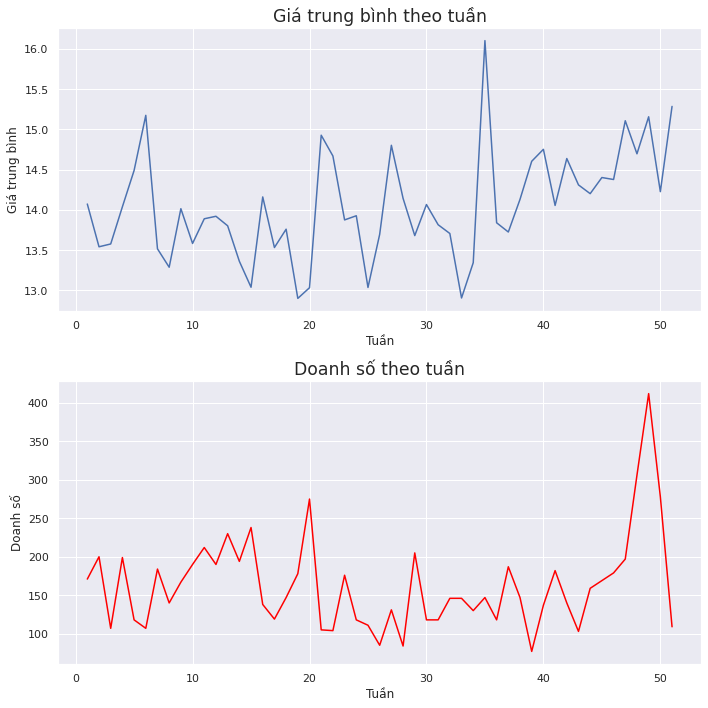

In [ ]:
fig, ax= plt.subplots(2,1, figsize = (10,10), facecolor = 'w', tight_layout = 5)
ax[0].plot(data_input.groupby('Week').UnitPrice.mean())
ax[0].set_xlabel('Tuần')
ax[0].set_ylabel('Giá trung bình')
ax[0].set_title('Giá trung bình theo tuần', size = 'x-large')

ax[1].plot(data_input.groupby('Week').Quantity.sum(), color = 'red')
ax[1].set_xlabel('Tuần')
ax[1].set_ylabel('Doanh số')
ax[1].set_title('Doanh số theo tuần', size = 'x-large')

plt.show()

Input: Tháng, đơn giá

Output: Doanh số dự đoán doanh số trong tháng đó

In [ ]:
Mean_Unit_price = np.array(data_input.groupby('Week').UnitPrice.mean())
Week = np.arange(1,52)
dataset2 = pd.DataFrame(data = Mean_Unit_price, columns= ['UPM'])
dataset2['Week'] = Week
dataset2['Qty'] = np.array(data_input.groupby("Week").Quantity.sum())
dataset2.head()

,UPM,Week,Qty
0,14.072759,1,171
1,13.541935,2,200
2,13.576957,3,107
3,14.038462,4,199
4,14.489062,5,118


In [ ]:
data_input['Week'].max()

51

[Text(0.5, 0, 'UPM'), Text(1.5, 0, 'Week'), Text(2.5, 0, 'Qty')]

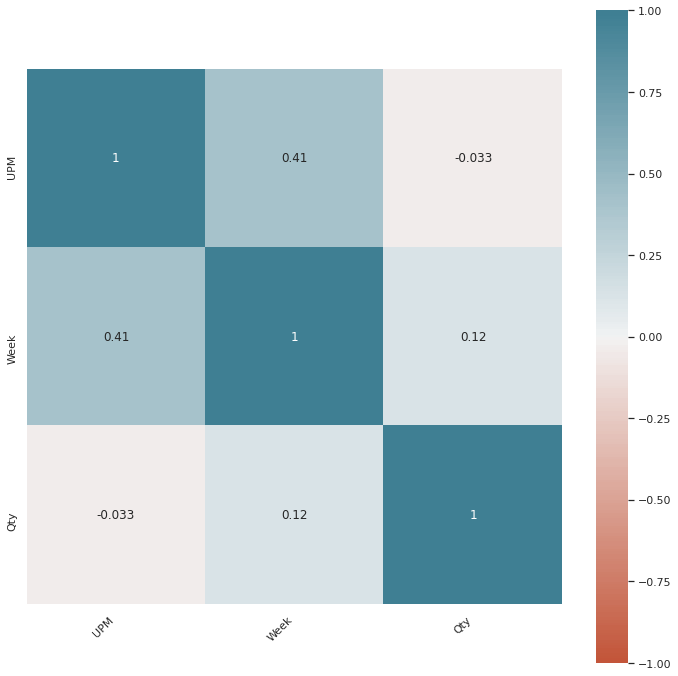

In [ ]:
corr = dataset2.corr(method= 'pearson')
fig, ax = plt.subplots(figsize=(12,12), facecolor = 'w')
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [ ]:
#Chia tập dữ liệu
X = dataset2[['UPM','Week']]
y = dataset2['Qty']

In [ ]:
X_train2, X_validation2, y_train2, y_validation2 = train_test_split(X, y, test_size = validation_size, random_state = seed)

In [ ]:
y_train2.shape, y_validation2.shape

((40,), (11,))

In [ ]:
models2 = []
models2.append(('LR', LinearRegression()))
models2.append(('LASSO', Lasso()))
models2.append(('EN', ElasticNet()))
models2.append(('RD', Ridge()))
models2.append(('KNN', KNeighborsRegressor()))
models2.append(('CART', DecisionTreeRegressor()))
models2.append(('SVR', SVR()))

In [ ]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

In [ ]:
# evaluate each model in turn
results2 = [] #Dữ liệu đánh giá các thuật toán
names2 = [] #Chứa tên để chạy các thuật toán Supervised learning
for name2, model2 in models2:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  #Đánh giá bằng hệ số Cross
  cv_results2 = cross_val_score(model2, X_train2, y_train2, cv=kfold, scoring=scoring)
  results2.append(cv_results2)
  names2.append(name2)
  msg = "%s: %f (%f)" % (name2, cv_results2.mean(), cv_results2.std())
  print(msg)

LR: -4785.615088 (4571.188359)
LASSO: -4786.819056 (4535.515499)
EN: -4732.072486 (4419.941267)
RD: -4776.876618 (4554.682524)
KNN: -3690.989000 (3266.293546)
CART: -7616.700000 (7450.219482)
SVR: -4781.552335 (5394.067248)


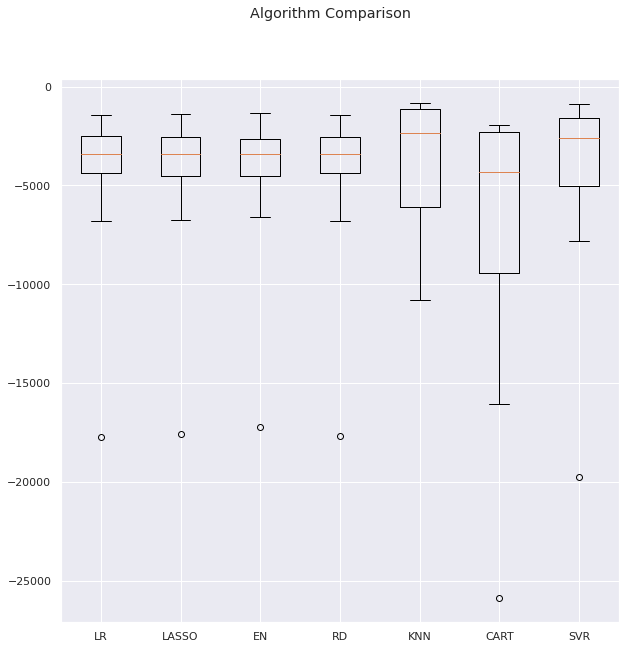

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor = 'w')
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('LASSO',Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results2 = []
names2 = []
for name2, model2 in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results2 = cross_val_score(model2, X_train2, y_train2, cv=kfold, scoring=scoring)
  results2.append(cv_results2)
  names2.append(name2)
  msg = "%s: %f (%f)" % (name2, cv_results2.mean(), cv_results2.std())
  print(msg)

ScaledLR: -4785.615088 (4571.188359)
ScaledLASSO: -4786.276763 (4593.078007)
ScaledRidge: -4773.626984 (4580.915456)
ScaledEN: -4692.376241 (4673.788193)
ScaledKNN: -4644.088000 (4088.819030)
ScaledCART: -8296.875000 (6898.494241)
ScaledSVR: -4858.010933 (5534.325805)


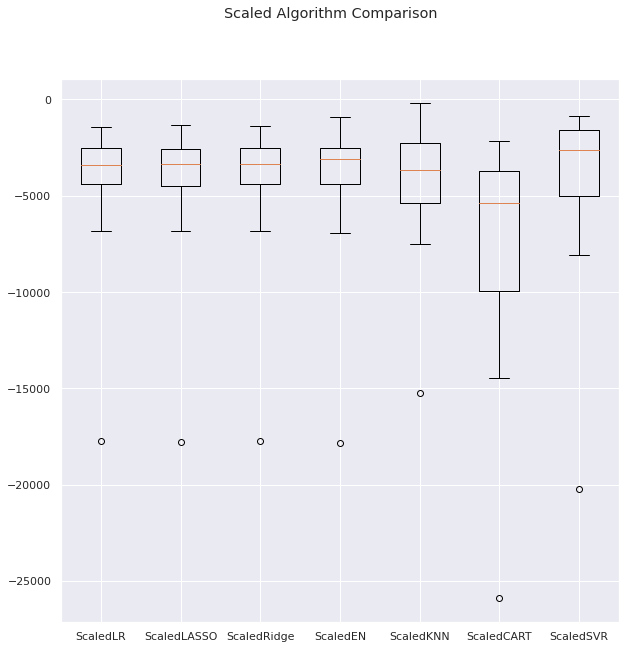

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10, 10), facecolor= 'w')
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

In [ ]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train2)
rescaledX = scaler.transform(X_train2)
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train2)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -4044.337245 using {'n_neighbors': 7}
-9153.875000 (7015.519885) with: {'n_neighbors': 1}
-5480.622222 (3416.105101) with: {'n_neighbors': 3}
-4544.452000 (4117.514875) with: {'n_neighbors': 5}
-4044.337245 (3821.991849) with: {'n_neighbors': 7}
-4295.037037 (4036.983452) with: {'n_neighbors': 9}
-4266.792975 (4291.652890) with: {'n_neighbors': 11}
-4298.888314 (4423.704601) with: {'n_neighbors': 13}
-4422.371444 (4864.470924) with: {'n_neighbors': 15}
-4459.240398 (4903.007713) with: {'n_neighbors': 17}
-4501.870152 (4998.526469) with: {'n_neighbors': 19}
-4620.181009 (5083.024428) with: {'n_neighbors': 21}


In [ ]:
# ensembles
ensembles = []
# boosting
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
# bagging
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train2, y_train2, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -6596.061302 (6730.814348)
ScaledGBM: -6604.330929 (6726.442878)
ScaledRF: -4874.990133 (4779.167617)
ScaledET: -5302.374023 (5182.300442)


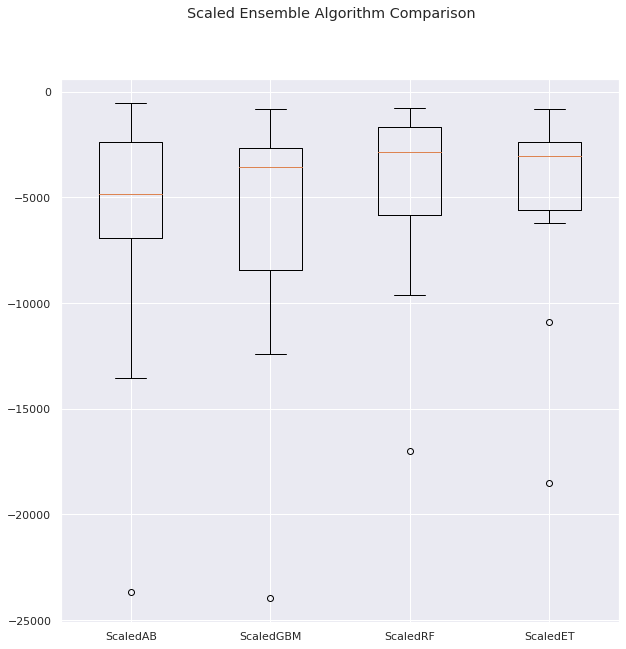

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
#Huấn luyện model
model = KNeighborsRegressor()
model.fit(X_train2, y_train2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
y_predict2 = model.predict(X_validation2)
mean_squared_error(y_validation2,y_predict2)

2012.76

In [ ]:
y_pred = model.predict(X)
mean_squared_error(y,y_pred)

2573.3403921568624

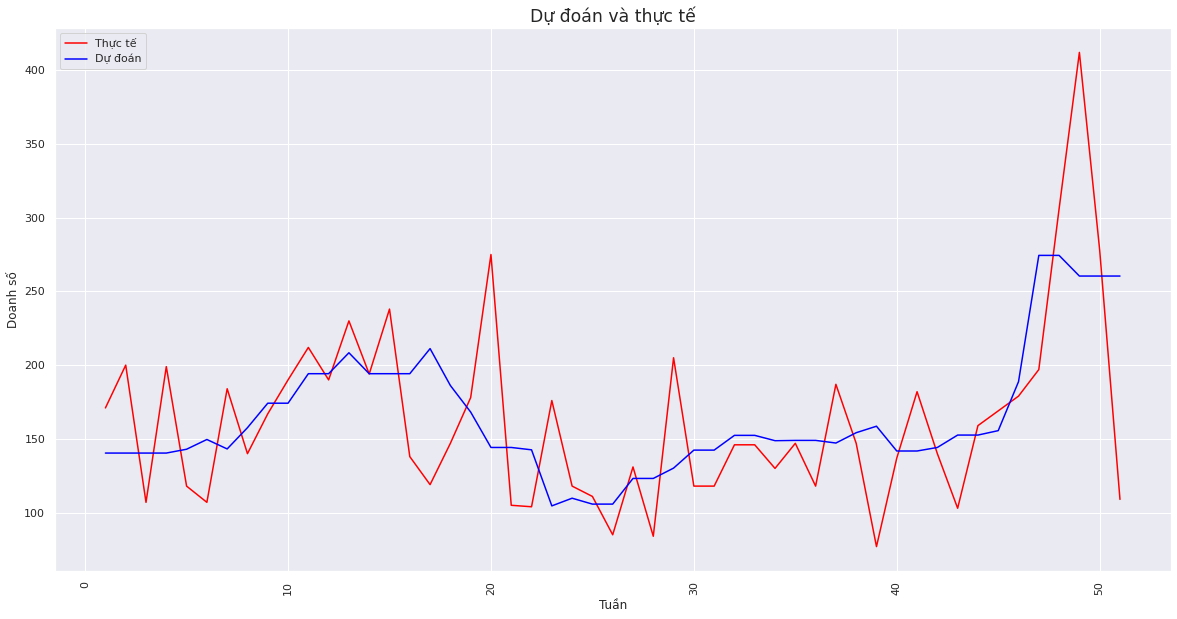

In [ ]:
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(X['Week'], y, color = 'red', label = 'Thực tế')
plt.plot(X['Week'], y_pred, color = 'blue', label = 'Dự đoán')
plt.xlabel('Tuần')
plt.ylabel('Doanh số')
plt.legend(loc = 'best')
plt.xticks(rotation=90)
plt.title("Dự đoán và thực tế", size = 'x-large')
plt.show()

In [ ]:
#Tối ưu mô hình với KNN
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_train2, y_train2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

In [ ]:
y_predict2 = model.predict(X_validation2)
mean_squared_error(y_validation2,y_predict2)

1440.8367346938776

In [ ]:
y_pred = model.predict(X)
mean_squared_error(y,y_pred)

2415.807523009204

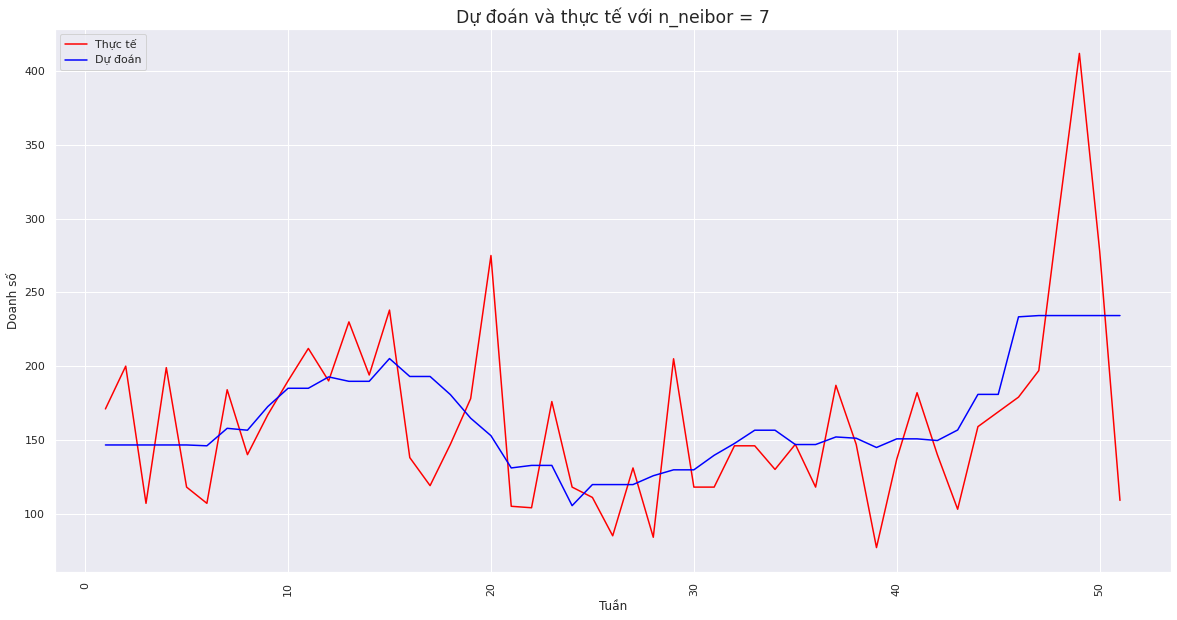

In [ ]:
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(X['Week'], y, color = 'red', label = 'Thực tế')
plt.plot(X['Week'], y_pred, color = 'blue', label = 'Dự đoán')
plt.xlabel('Tuần')
plt.ylabel('Doanh số')
plt.legend(loc = 'best')
plt.xticks(rotation=90)
plt.title("Dự đoán và thực tế với n_neibor = 7", size = 'x-large')
plt.show()

In [ ]:
scaler = StandardScaler().fit(X_train2)
rescaledX = scaler.transform(X_train2)
model = KNeighborsRegressor(n_neighbors= 7)
model.fit(rescaledX, y_train2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

In [ ]:
rescaledValidationX = scaler.transform(X_validation2)
y_pred = model.predict(rescaledValidationX)
print(mean_squared_error(y_validation2, y_pred))

1138.3803339517624


In [ ]:
rescaledValidationX_ = scaler.transform(X)
y_pred_best = model.predict(rescaledValidationX_)
print(mean_squared_error(y, y_pred_best))

2721.809523809523


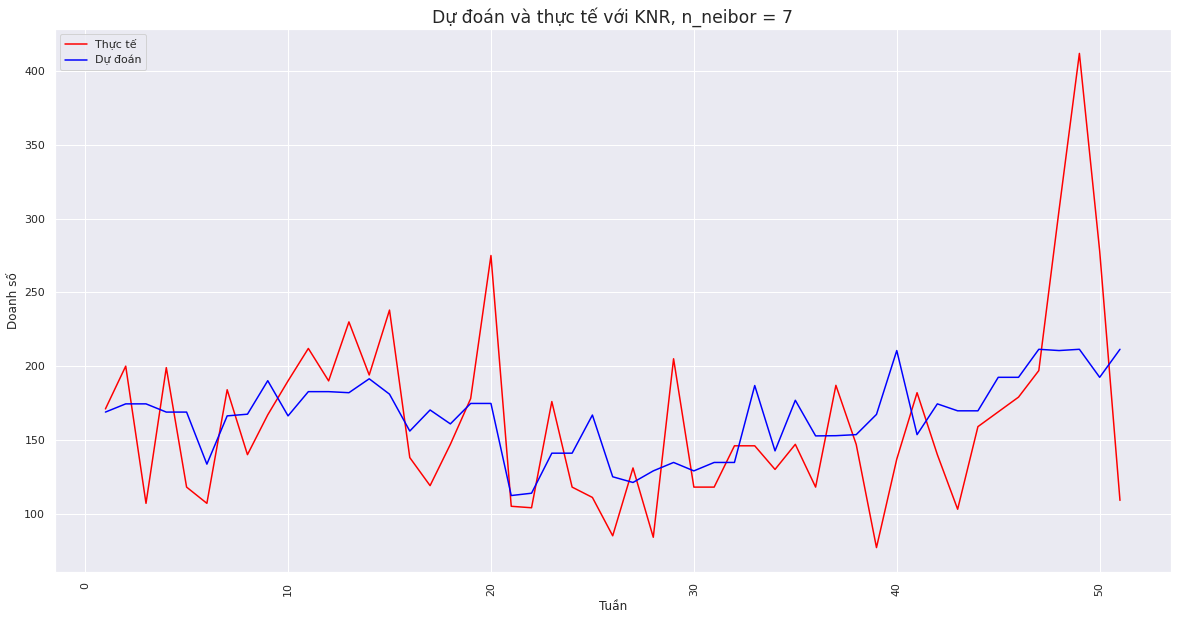

In [ ]:
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(X['Week'], y, color = 'red', label = 'Thực tế')
plt.plot(X['Week'], y_pred_best, color = 'blue', label = 'Dự đoán')
plt.xlabel('Tuần')
plt.ylabel('Doanh số')
plt.legend(loc = 'best')
plt.xticks(rotation=90)
plt.title("Dự đoán và thực tế với KNR, n_neibor = 7", size = 'x-large')
plt.show()

In [ ]:
model3 = Ridge()
model3.fit(X_train2, y_train2)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred3 = model3.predict(X_validation2)
mean_squared_error(y_validation2,y_pred3)

2373.4851471392412

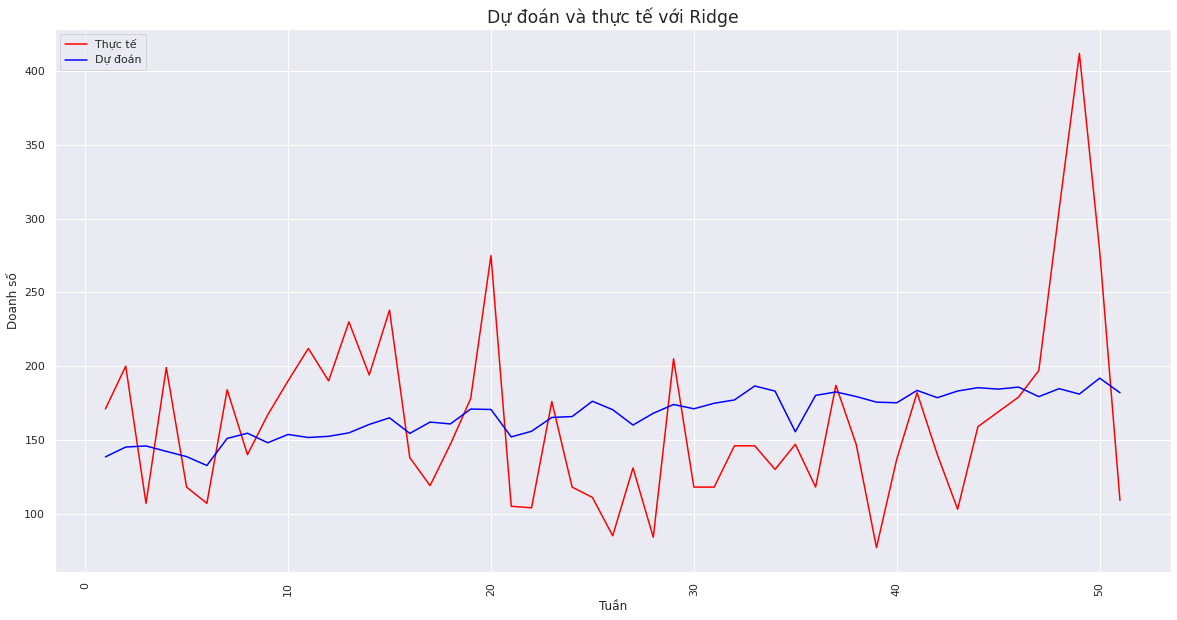

In [ ]:
y_pred3_ = model3.predict(X)
plt.figure(figsize=(20,10), facecolor = 'w')
plt.plot(X['Week'], y, color = 'red', label = 'Thực tế')
plt.plot(X['Week'], y_pred3_, color = 'blue', label = 'Dự đoán')
plt.xlabel('Tuần')
plt.ylabel('Doanh số')
plt.legend(loc = 'best')
plt.xticks(rotation=90)
plt.title("Dự đoán và thực tế với Ridge", size = 'x-large')
plt.show()